In [63]:
import torch
from torch import Tensor, LongTensor, tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss, L1Loss, ReLU, Module, NLLLoss, Sigmoid
from torch.optim import LBFGS
import torch.optim as optim
from torch import cat, no_grad, manual_seed
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import time

from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
from qiskit_algorithms.utils import algorithm_globals
from qiskit.quantum_info import SparsePauliOp

from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector 

## Importing the dataset

In [3]:
file_path = "../Fraud-Detection-with-QML/dataset/dataset.csv"

try:
    df = pd.read_csv(file_path)
    print("Dataset imported successfully.")
except FileNotFoundError:
    print("File not found. Please check the file path.")
    exit()


Dataset imported successfully.


## Data cleaning

In [4]:
df.drop(columns=['step'], inplace=True)
df.drop(columns=['zipcodeOri'], inplace=True)
df.drop(columns=['zipMerchant'], inplace=True)
df.drop(columns=['customer'], inplace=True)
df.drop(columns=['merchant'], inplace=True)

In [5]:
encoder = LabelEncoder()

encoded_age = encoder.fit_transform(df['age'])
df['age'] = encoded_age
encoded_gender = encoder.fit_transform(df['gender'])  #This could be a binary encoding (or not)
df['gender'] = encoded_gender
encoded_category = encoder.fit_transform(df['category']) #This could be a binary encoding
df['category'] = encoded_category


## Undersampling

In [6]:
X = df.drop('fraud', axis=1)
y = df['fraud']

# undesapling the dataset to have only 100 fraud and 100 non-fraud samples
sampling_strategy = {0: 100, 1: 100}

# Undersample the majority class
undersample = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X, y)

In [7]:
print(X_resampled.shape[0])
print(type(X_resampled))

200
<class 'pandas.core.frame.DataFrame'>


# Datasets

In [8]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

(140, 4) (60, 4)


In [9]:
#Defining the "Thin" dataset
X_Thin_train = MinMaxScaler().fit_transform(X_train)
X_Thin_test = MinMaxScaler().fit_transform(X_test)

In [10]:
# Defining the "Large" dataset

# X_Large_train
cat0 = []
cat1 = []
cat2 = []
cat3 = []

category = list(X_train['category'])
for i in range(X_train.shape[0]):
    # Convert to binary and remove the '0b' prefix
    binstr = bin(category[i])[2:]
    while len(binstr)<4:
        binstr = '0'+binstr
    #creating the classes for the 0th, 1st, 2nd and 3rd bit of the binary encoding 
    cat0.append(binstr[3])
    cat1.append(binstr[2])
    cat2.append(binstr[1])
    cat3.append(binstr[0])

d = {'age': list(X_train['age']), 'gender': list(X_train['gender']),'cat3': cat3, 'cat2': cat2, 'cat1': cat1, 'cat0': cat0, 'amount': list(X_train['amount'])}

X_Large_train = pd.DataFrame(data=d)
X_Large_train = MinMaxScaler().fit_transform(X_Large_train)



#X_Large_test
cat0 = []
cat1 = []
cat2 = []
cat3 = []

category = list(X_test['category'])
for i in range(X_test.shape[0]):
    # Convert to binary and remove the '0b' prefix
    binstr = bin(category[i])[2:]
    while len(binstr)<4:
        binstr = '0'+binstr
    #creating the classes for the 0th, 1st, 2nd and 3rd bit of the binary encoding 
    cat0.append(binstr[3])
    cat1.append(binstr[2])
    cat2.append(binstr[1])
    cat3.append(binstr[0])

d = {'age': list(X_test['age']), 'gender': list(X_test['gender']),'cat3': cat3, 'cat2': cat2, 'cat1': cat1, 'cat0': cat0, 'amount': list(X_test['amount'])}

X_Large_test = pd.DataFrame(data=d)
X_Large_test = MinMaxScaler().fit_transform(X_Large_test)


In [11]:
# Transforming the y dataframes in to ndarrays

# y01 represent the arrays of values between 0 and 1 (used for the sampler and the hybrid)
y01_train = y_train.to_numpy()
y01_test = y_test.to_numpy()

# these y are in the range (-1, 1) and are used for the estimator
y_train = (y01_train * 2) - 1
y_test = (y01_test * 2) - 1

# Feature maps

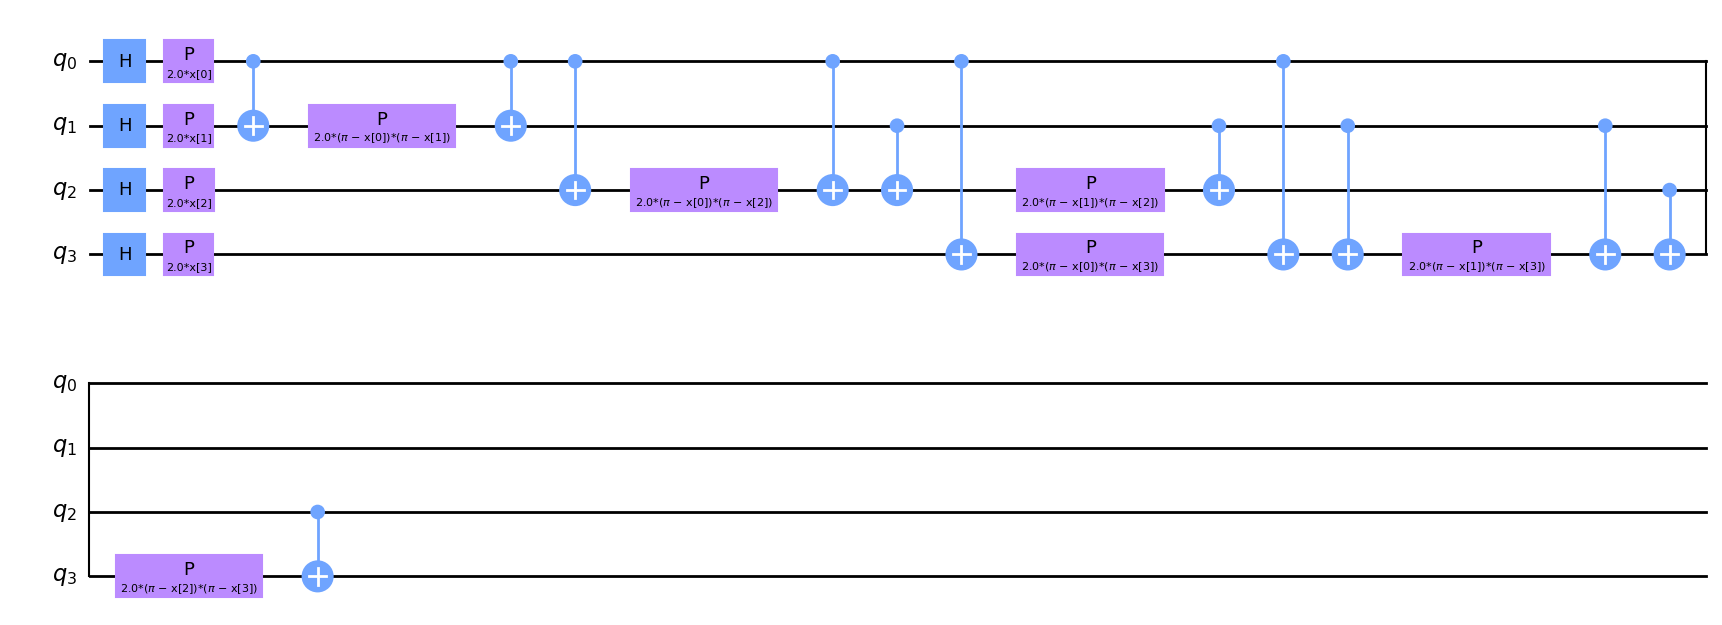

In [51]:
ZZ = ZZFeatureMap(feature_dimension=4, reps=1)   
ZZ.decompose().draw(output='mpl')

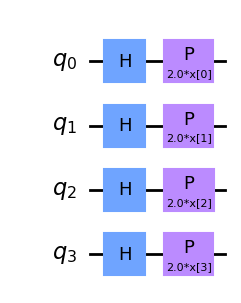

In [13]:
Z = ZFeatureMap(feature_dimension=4, reps=1)
Z.decompose().draw(output='mpl')

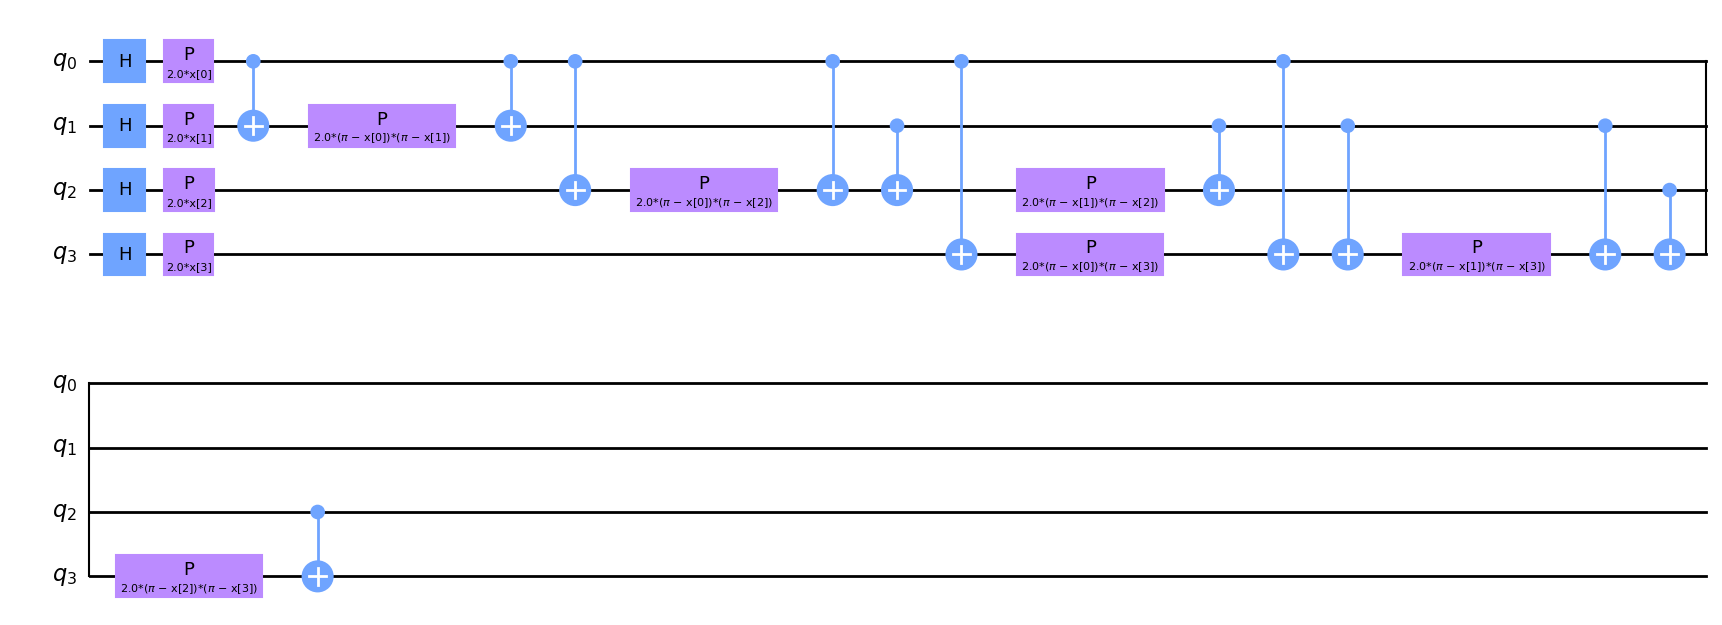

In [52]:
P = PauliFeatureMap(feature_dimension=4, reps=1)#, paulis = ['Z', 'X', 'ZY'])   # feature_dimension = num_features
P.decompose().draw(output='mpl')

# Quantum ML models 

## Estimator QNN

The EstimatorQNN is a neural network that takes in a parametrized quantum circuit with designated parameters for input data and/or weights, an optional observable(s) and outputs their expectation value(s)

## Sampler QNN

The SamplerQNN is a network based on the samples resulting from measuring a quantum circuit. 
Differently from the estimator qnn does not require a custom observable.However, the SamplerQNN also allows us to specify an interpret function to post-process the samples.
It's important to note that if a custom interpret function is defined, the output_shape cannot be inferred by the network, and needs to be provided explicitly.

## Hybrid QNN

The HybridQNN is a classical neural network in which some classical layer are replaced by qnn.
The implementation in Qiskit uses the `TorchConnector` class. After defining our quantum neural network layer (in this case, a EstimatorQNN), we can embed it into a layer in our torch Module by initializing a torch connector as `TorchConnector(qnn)`.
In order to have an adequate gradient backpropagation in hybrid models, we MUST set the initial parameter `input_gradients` to TRUE during the qnn initialization.

### Testing the models

In [15]:
algorithm_globals.random_seed = 42 #Qiskit random seed
manual_seed(42) #Torch random seed

In [66]:
#Model creation, training and evaluation

hybrid_dim = 3
hidden_dim = 10
epochs = 10  # Set number of epochs for hybrid model

for dataset_name in ("Thin", "Large"):
    for feature_map_name in ("Z", "ZZ", "P"):
        for model_name in ("Estimator", "Sampler", "Hybrid"):
            
            acc = 0
            
            #Choosing the dataset format
            if dataset_name == "Thin":
                X_train = X_Thin_train
                X_test = X_Thin_test
            else:
                X_train = X_Large_train
                X_test = X_Large_test
                
            dims = X_train.shape[1]    # Dimension of the circuit
                
            #Chosing the feature map
            if feature_map_name == "Z":
                feature_map = ZFeatureMap(feature_dimension=dims, reps=1)
            elif feature_map_name == "ZZ":
                feature_map = ZZFeatureMap(feature_dimension=dims, reps=1) 
            else:
                feature_map = PauliFeatureMap(feature_dimension=dims, reps=1, paulis = ['Z', 'X', 'ZY'])
              
            # Start timing
            start = time.time()
            
            # Chosing the model between Estimator, Sampler and Hybrid
            
            if model_name == "Estimator":
                
                observable1 = SparsePauliOp.from_list([("Y" * dims, 1)])  # observable of the estimator QNN
                ansatz = RealAmplitudes(num_qubits=dims)
                qc = QuantumCircuit(dims)
                qc.compose(feature_map, inplace=True)
                qc.compose(ansatz, inplace=True)
                
                # Building the circuit
                Eqnn = EstimatorQNN(
                    circuit=qc,
                    observables=observable1,
                    input_params=feature_map.parameters,
                    weight_params=ansatz.parameters
                )
                
                Eqnn.input_gradients = True  # Used for torch connector
                initial_weights = 0.1 * (2 * algorithm_globals.random.random(Eqnn.num_weights) - 1)
                
                # Building the model
                model = TorchConnector(Eqnn, initial_weights=initial_weights)
                optimizer = LBFGS(model.parameters())
                f_loss = MSELoss()
                model.train() # Starting the train mode
                X_ = tensor(X_train).float()
                y_ = tensor(y_train).reshape(-1, 1).float()
                
                # Some optimization algorithms such as LBFGS need to
                # reevaluate the function multiple times, so you have to
                # pass in a closure that allows them to recompute your model.
                # The closure should clear the gradients, compute the loss,
                # and return it.
                def closure():
                    optimizer.zero_grad()  # Initialize/clear gradients
                    loss = f_loss(model(X_), y_)  # Evaluate loss function
                    loss.backward()  # Backward pass
                    #print(loss.item())  # Print loss
                    return loss
                
                # Training
                optimizer.step(closure)
                
                # Evaluation
                model.eval() # Starting the evaluation mode
                acc = 0
                for x, y_target in zip(X_test, y_test):
                    output = (model(tensor(x))).detach().numpy()
                    res = np.sign(output[0])
                    if res == y_target:
                        acc += 1
                acc = acc/len(y_test)
                
                
            elif model_name == "Sampler":
                
                ansatz = RealAmplitudes(num_qubits=dims, entanglement="linear", reps=1)
                qc = QuantumCircuit(dims)
                qc.compose(feature_map, inplace=True)
                qc.compose(ansatz, inplace=True)
                
                # If we define a custom interpret function ( in the example: parity)
                # we must remember to explicitly provide the desired output shape
                # The function "parity" transforms x into binary and sums the 1s
                # and returns modulo 2 of the sum
                parity = lambda x: "{:b}".format(x).count("1") % 2 
                output_shape = 2  # parity = 0, 1
                
                # Building the circuit
                Sqnn = SamplerQNN(
                    circuit=qc,
                    input_params=feature_map.parameters,
                    weight_params=ansatz.parameters,
                    interpret=parity,
                    output_shape=output_shape,
                )
                initial_weights = 0.1 * (2 * algorithm_globals.random.random(Sqnn.num_weights) - 1)
                
                # Building the model
                model = TorchConnector(Sqnn, initial_weights)
                optimizer = LBFGS(model.parameters())
                f_loss = CrossEntropyLoss()  # Our output will be in the [0,1] range so we can use the crossentropy
                model.train()  # starting the train mode
                X_ = tensor(X_train)
                y01_ = tensor(y01_train).reshape(-1).long() #This should be in the range (0,1) an should be a 1 dim tensor
                def closure():
                    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
                    loss = f_loss(model(X_), y01_)  # Calculate loss
                    loss.backward()  # Backward pass
                    return loss
                
                # Training
                optimizer.step(closure)
                
                # Evaluation
                model.eval() # Starting the evaluation mode
                acc = 0
                for x, y_target in zip(X_test, y01_test):
                    output = (model(tensor(x))).detach().numpy()
                    res = list(output).index(max(output))
                    if res == y_target:
                        acc += 1
                acc = acc/len(y01_test)
            
            elif model_name == "Hybrid":
                
                # Building a new feature map since the dimension of the quantum
                # layer is different from "dims"
                if feature_map_name == "Z":
                    feature_map = ZFeatureMap(feature_dimension=hybrid_dim, reps=1)
                elif feature_map_name == "ZZ":
                    feature_map = ZZFeatureMap(feature_dimension=hybrid_dim, reps=1) 
                else:
                    feature_map = PauliFeatureMap(feature_dimension=hybrid_dim, reps=1, paulis = ['Z', 'X', 'ZY'])
                    
                ansatz = RealAmplitudes(hybrid_dim, reps=1)
                qc = QuantumCircuit(hybrid_dim)
                qc.compose(feature_map, inplace=True)
                qc.compose(ansatz, inplace=True)
                
                # Building circuit. It's gonna be an estimator QNN
                Hqnn = EstimatorQNN(
                    circuit=qc,
                    input_params=feature_map.parameters,
                    weight_params=ansatz.parameters,
                    input_gradients=True,
                )
                
                # Defining the hybrid QNN
                class Net(Module):
                    def __init__(self, Hqnn):
                        super().__init__()
                        self.fc1 = Linear(dims, hidden_dim)
                        self.fc2 = Linear(hidden_dim, hybrid_dim)  # input to QNN
                        self.Hqnn = TorchConnector(Hqnn)  # Apply torch connector
                        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN
                        self.sig = Sigmoid()  # Sigmoid function

                    def forward(self, x):
                        x = F.relu(self.fc1(x))
                        x = self.fc2(x)
                        x = self.Hqnn(x)  # apply QNN
                        x = self.fc3(x)
                        x = self.sig(x)
                        return cat((x, 1 - x), -1)
                
                # Building the model
                model = Net(Hqnn)
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                loss_func = NLLLoss()
                model.train()  # Set the model to training mode
                
                # Training the model (here we need do repeat the optimization step on different epochs)
                for epoch in range(epochs):
                    for x_, y_ in zip(X_train, y01_train):
                        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
                        output = model(tensor(x_).float())  # Forward pass
                        loss = loss_func(output, tensor(y_))  # Calculate loss
                        loss.backward()  # Backward pass
                        optimizer.step()  # Optimize weights
                        
                # Evaluation
                model.eval()  # set model to evaluation mode
                with no_grad():
                    acc = 0
                    for x, y_target in zip(X_test, y01_test):
                        output = (model(tensor(x).float())).detach().numpy()
                        res = list(output).index(max(output))
                        if res == y_target:
                            acc += 1
                    acc = acc/len(y01_test)
            
            
            #End timing
            end = time.time()
            elapsed = end-start
            
            
            print(f"Time spent for {model_name} QNN with feature map {feature_map_name} and dataset {dataset_name} : {elapsed}")
            print(f"The accuracy is : {acc}")
            print("- - - - -")
        
            

Time spent for Estimator QNN with feature map Z and dataset Thin : 415.18162631988525
The accuracy is : 0.5666666666666667
- - - - -
Time spent for Sampler QNN with feature map Z and dataset Thin : 112.45719623565674
The accuracy is : 0.5666666666666667
- - - - -
[0.6961619  0.30383807]
[0.5794548  0.42054522]
[0.52220845 0.47779155]
[0.6795778  0.32042217]
[0.50134903 0.49865097]
[0.5636632  0.43633682]
[0.67530584 0.32469416]
[0.55019414 0.44980586]
[0.68501544 0.31498456]
[0.6009246 0.3990754]
[0.6867955  0.31320453]
[0.52952284 0.47047716]
[0.48632407 0.5136759 ]
[0.48278025 0.5172198 ]
[0.6905683  0.30943167]
[0.6826228 0.3173772]
[0.6847756 0.3152244]
[0.57608944 0.42391056]
[0.6972537 0.3027463]
[0.68910956 0.31089044]
[0.49296638 0.5070336 ]
[0.5358732  0.46412683]
[0.6887641 0.3112359]
[0.65096706 0.34903294]
[0.5558797 0.4441203]
[0.6114826  0.38851738]
[0.50918865 0.49081135]
[0.6612972 0.3387028]
[0.67695093 0.32304907]
[0.6879419 0.3120581]
[0.6915478 0.3084522]
[0.662393 

KeyboardInterrupt: 